# Local Benchmarking to compare Koorde and Chord

This is a simple testing file to compare the Chord and Koorde lookup datastructures locally on the basis of:

1. The average number of hops to find a node responsible for the value $v$ associated to some key $k$ of interest.

2. For a given number of nodes what is the PDF of the hops?

We extend this to realistic testing on the SimGrid emulator to benchmark variables which can't be captured by a simple local test such as lookup latencies, and so on.

In [15]:
import VanillaChord as vc
import VanillaKoorde as vk
import numpy as np

def join_and_initialize(nodes, keystring = 'ChordNode_'):
    # Initialize single node for joins
    key_anchor = keystring+'0'
    N = len(nodes)
    # Join and instantiate a Chord or Koorde network
    for j in range(N):
        node_key = keystring+f'{j}'
        nodes[node_key].join(nodes[key_anchor])
    return nodes

'''
Begin local testing of the "vanilla" impls of Chord and Koorde.
'''
# Number of nodes to generate for each step of the simulation
num_nodes = [8,16,32,64,128,256]

# Number of replicates per iteration
num_rep = 40

# Bits to represent the IDs. Kept consistent between iterations
m = 25
Q = 2**m

NumHopsChord = [[] for _ in range(len(num_nodes)) ]
NumHopsKoorde = [[]  for _ in range(len(num_nodes)) ]

for i in range(len(num_nodes)):
    
    # Generate and join N node objects
    N = num_nodes[i]
    
    # Initialize random IDs
    IDs = np.random.randint(low=0, high=Q, size=N)
    
    # Initialization a number of Chord and Koorde nodes
    Chord_Nodes = {f'ChordNode_{j}': vc.Chord_Node(IDs[j], m) for j in range(N)}
    Koorde_Nodes = {f'KoordeNode_{j}': vk.Koorde_Node(IDs[j], m) for j in range(N)}
    
    # Instantiate the Koorde and Chord lookup distributed data-structures
    Chord_Nodes = join_and_initialize(Chord_Nodes, keystring = 'ChordNode_')
    Koorde_Nodes = join_and_initialize(Koorde_Nodes, keystring = 'KoordeNode_')
    
    '''
    1. NumHops test: sample random keys and look their successors 
    up with respect to rep_num random nodes with consistent IDs.
    '''
    keys = np.random.randint(low=0, high=Q, size=num_rep)
    node_ids = np.random.randint(low=0, high=N, size=num_rep)

    print('---Example Finger Table---')
    vc.print_fingers(Chord_Nodes[f'ChordNode_{0}'], m=m) # can easily check that it's correct
    
    for l in range(node_ids.shape[0]):
        # randomly sampled Chord node
        node_C = Chord_Nodes[f'ChordNode_{node_ids[l]}']
        # Koorde node (same ID as Chord node)
        node_K = Koorde_Nodes[f'KoordeNode_{node_ids[l]}']
        
        for k in range(keys.shape[0]):
            numhopsChord = node_C.find_pred(keys[k], count_hops=True) # here the count adds one to account for successor
            if l == 0 and k == 0:
                print(f'counted {numhopsChord} hops to find key {keys[k]}')
            
            NumHopsChord[i].append(numhopsChord)
            
            numhopsKoorde = node_K.find_succ(keys[k], count_hops=True)
            NumHopsKoorde[i].append(numhopsKoorde)
            
    '''
    2. Keys/node test
    '''
    
    '''
    3. Keys/node PDF
    '''

---Example Finger Table---
Finger table of 8052930
start | interval | finger
8052931 | (8052931, 8052932) | 11791086
8052932 | (8052932, 8052934) | 11791086
8052934 | (8052934, 8052938) | 11791086
8052938 | (8052938, 8052946) | 11791086
8052946 | (8052946, 8052962) | 11791086
8052962 | (8052962, 8052994) | 11791086
8052994 | (8052994, 8053058) | 11791086
8053058 | (8053058, 8053186) | 11791086
8053186 | (8053186, 8053442) | 11791086
8053442 | (8053442, 8053954) | 11791086
8053954 | (8053954, 8054978) | 11791086
8054978 | (8054978, 8057026) | 11791086
8057026 | (8057026, 8061122) | 11791086
8061122 | (8061122, 8069314) | 11791086
8069314 | (8069314, 8085698) | 11791086
8085698 | (8085698, 8118466) | 11791086
8118466 | (8118466, 8184002) | 11791086
8184002 | (8184002, 8315074) | 11791086
8315074 | (8315074, 8577218) | 11791086
8577218 | (8577218, 9101506) | 11791086
9101506 | (9101506, 10150082) | 11791086
10150082 | (10150082, 12247234) | 11791086
12247234 | (12247234, 16441538) | 15292

In [34]:
#print(NumHopsChord)

In [17]:

NumHopsChord = np.array(NumHopsChord).T
NumHopsKoorde = np.array(NumHopsKoorde).T

In [18]:
import matplotlib.pyplot as plt

def whisker_plot(x, y_bot, y_diff, ylabel="", xlabel="", title="", \
                 errbarlabel = r"$5^{th}$, $95^{th}$ percentiles", \
                 centerlabel=r"$50^{th}$ percentile", \
                line=True):
    if line:
        print(np.zeros_like(y_bot).shape)
        print(y_diff.shape)
        plt.errorbar(x, y_bot, yerr=(np.zeros_like(y_bot), y_diff), capsize=1, \
                     ecolor='black', ls='', lw=1, capthick=1, \
                     label=errbarlabel, alpha=0.6)
        plt.plot(x, y_bot + (1/2)*y_diff, marker='d', \
                 color='black', linestyle='--', \
                 label=centerlabel, alpha=0.6)
    else:
        plt.errorbar(x, y_bot, yerr=(np.zeros_like(y_bot), y_diff), capsize=1, \
                     ecolor='black', ls='', lw=1, capthick=1, \
                     label=errbarlabel, alpha=0.6)
        plt.plot(x, y_bot + (1/2)*y_diff, marker='d', color='black', \
                 ls='', label=centerlabel, alpha=0.6)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    return

def whisker_plot_combined(x, y_botA, y_diffA, y_botB, y_diffB, \
                          ylabel="", xlabel="", title="", \
                 errbarlabelA = r"$5^{th}$, $95^{th}$ percentiles", \
                 centerlabelA = r"$50^{th}$ percentile", \
                errbarlabelB = r"$5^{th}$, $95^{th}$ percentiles", \
                 centerlabelB = r"$50^{th}$ percentile"):
    # Plot A
    plt.errorbar(x, y_botA, yerr=(np.zeros_like(y_botA), y_diffA), capsize=1, \
                 ecolor='blue', ls='', lw=1, capthick=1, \
                 label=errbarlabelA, alpha=0.6)
    plt.plot(x, y_botA + (1/2)*y_diffA, marker='d', \
             color='blue', linestyle='--', \
             label=centerlabelA, alpha=0.6)
    # Plot B
    plt.errorbar(x, y_botB, yerr=(np.zeros_like(y_botB), y_diffB), capsize=1, \
                 ecolor='red', ls='', lw=1, capthick=1, \
                 label=errbarlabelB, alpha=0.6)
    plt.plot(x, y_botB + (1/2)*y_diffB, marker='d', \
             color='red', linestyle='--', \
             label=centerlabelB, alpha=0.6)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    return

[[3 4 4 3 5 4]
 [4 3 2 5 6 7]
 [1 3 2 5 2 5]
 ...
 [2 3 3 5 6 3]
 [4 2 2 4 3 7]
 [1 3 2 3 3 5]]
(6,)
(6,)


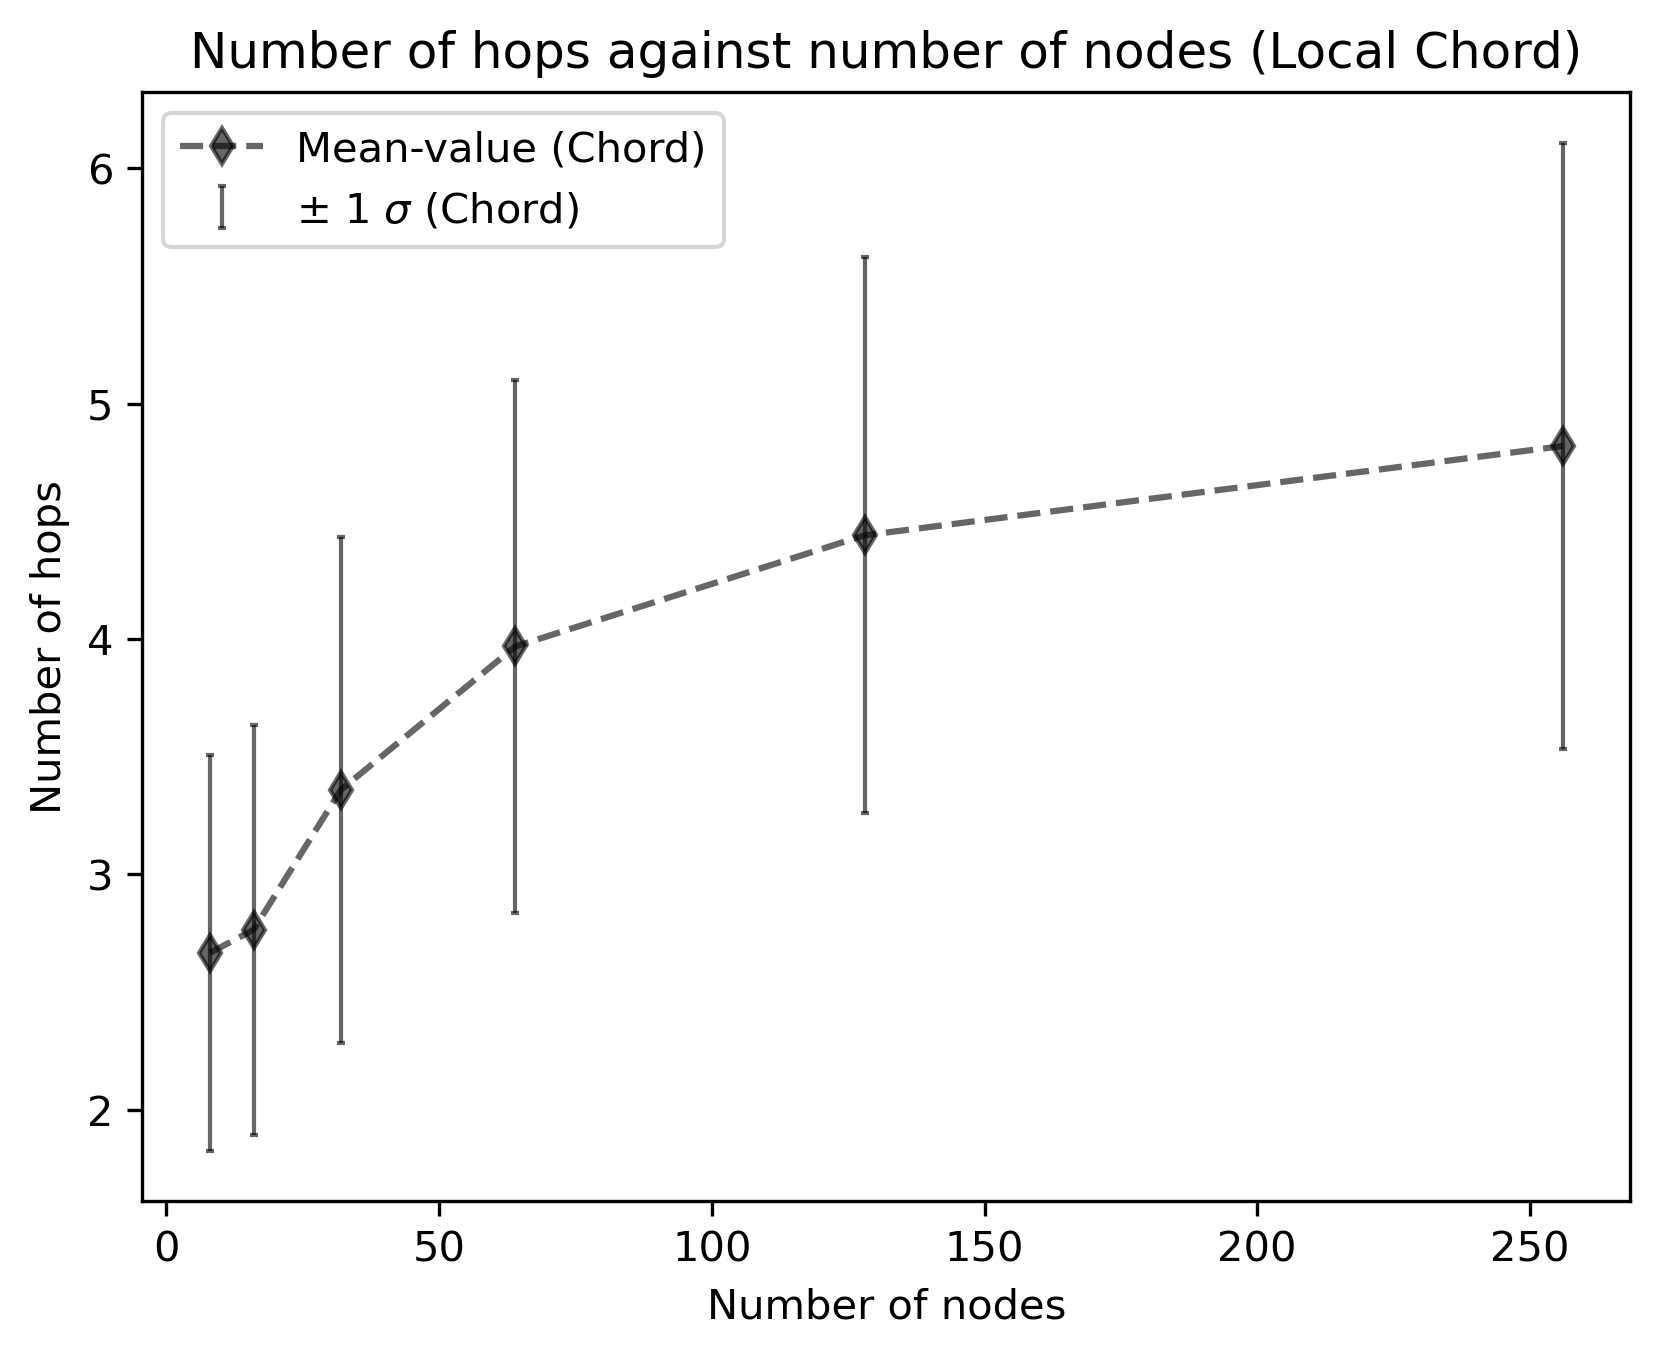

(6,)
(6,)


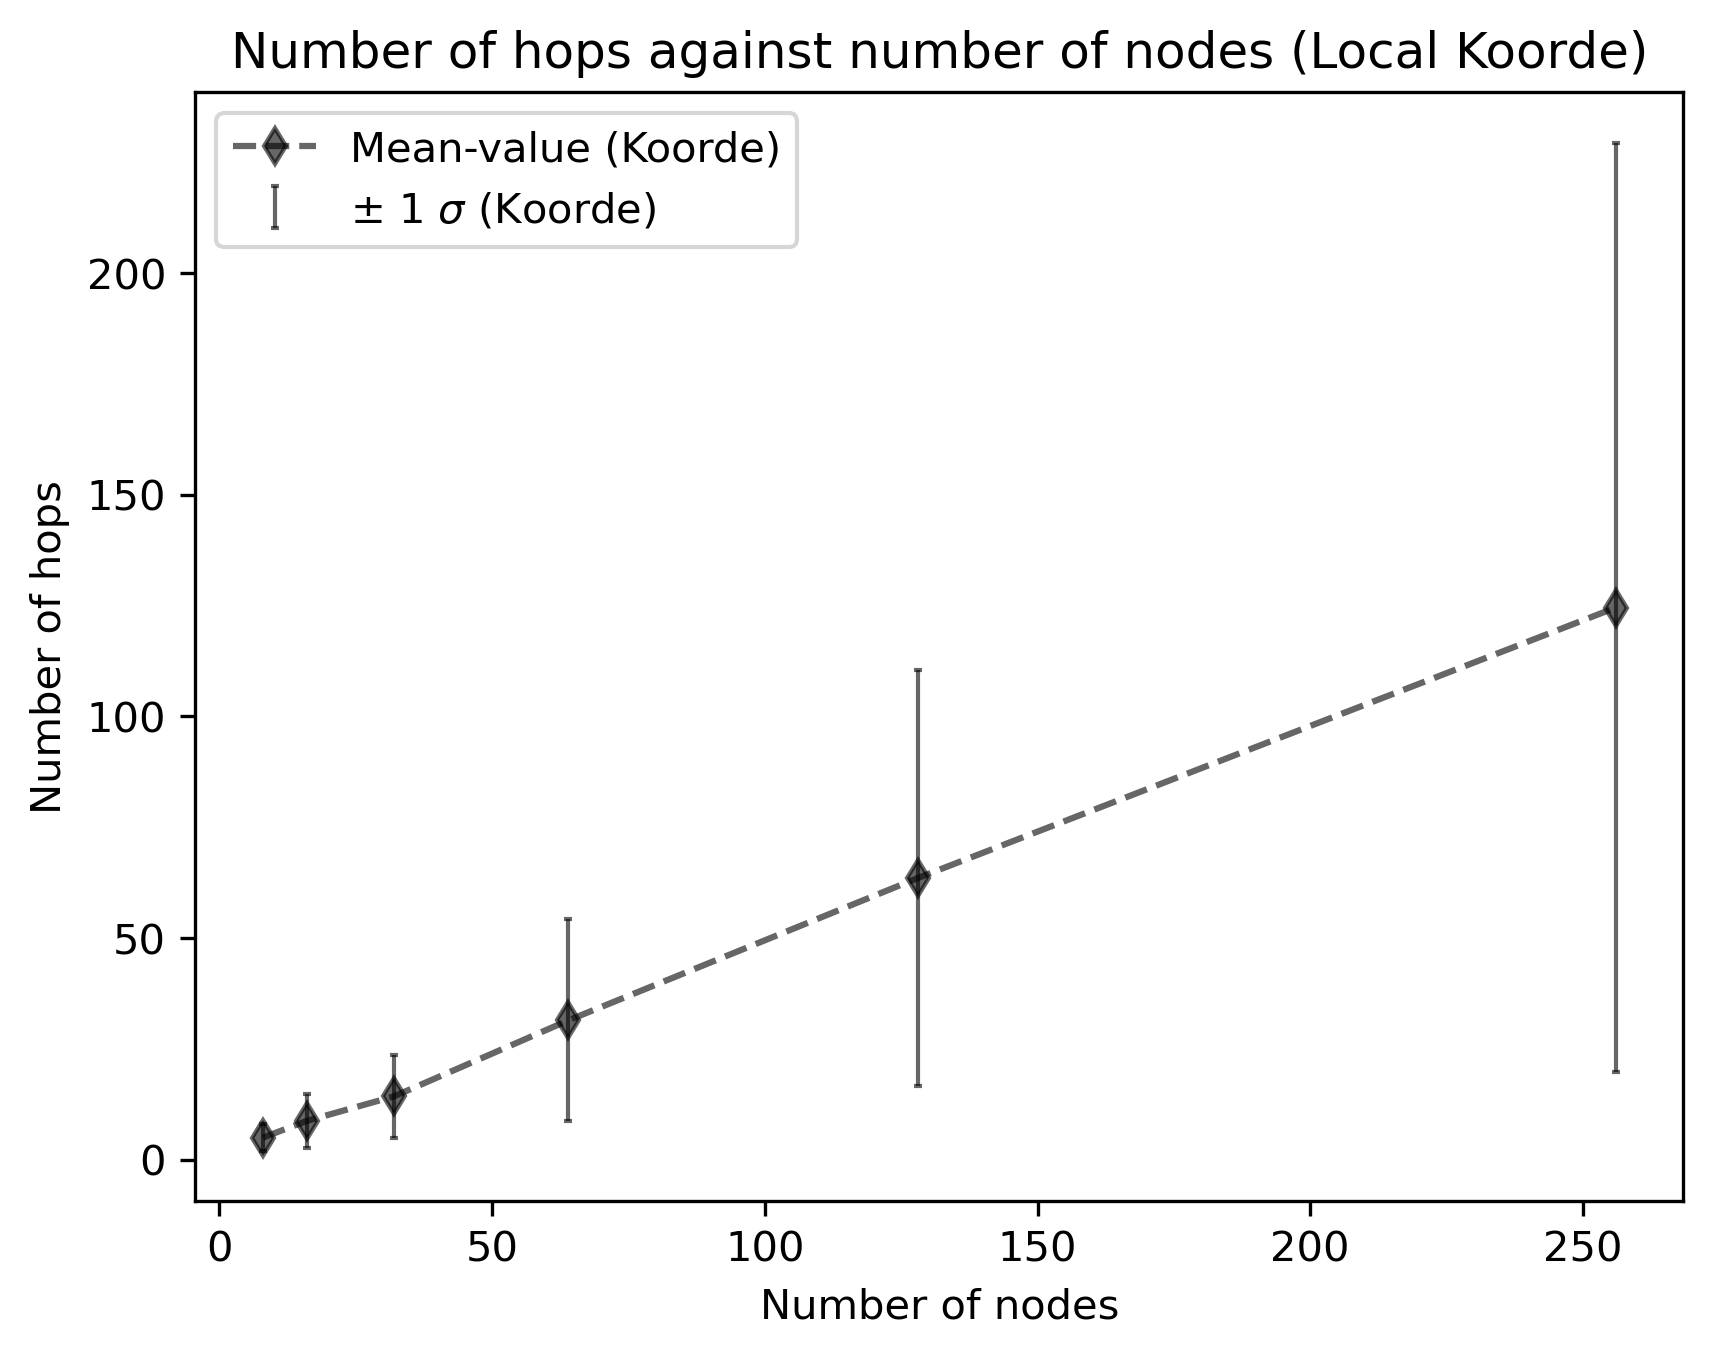

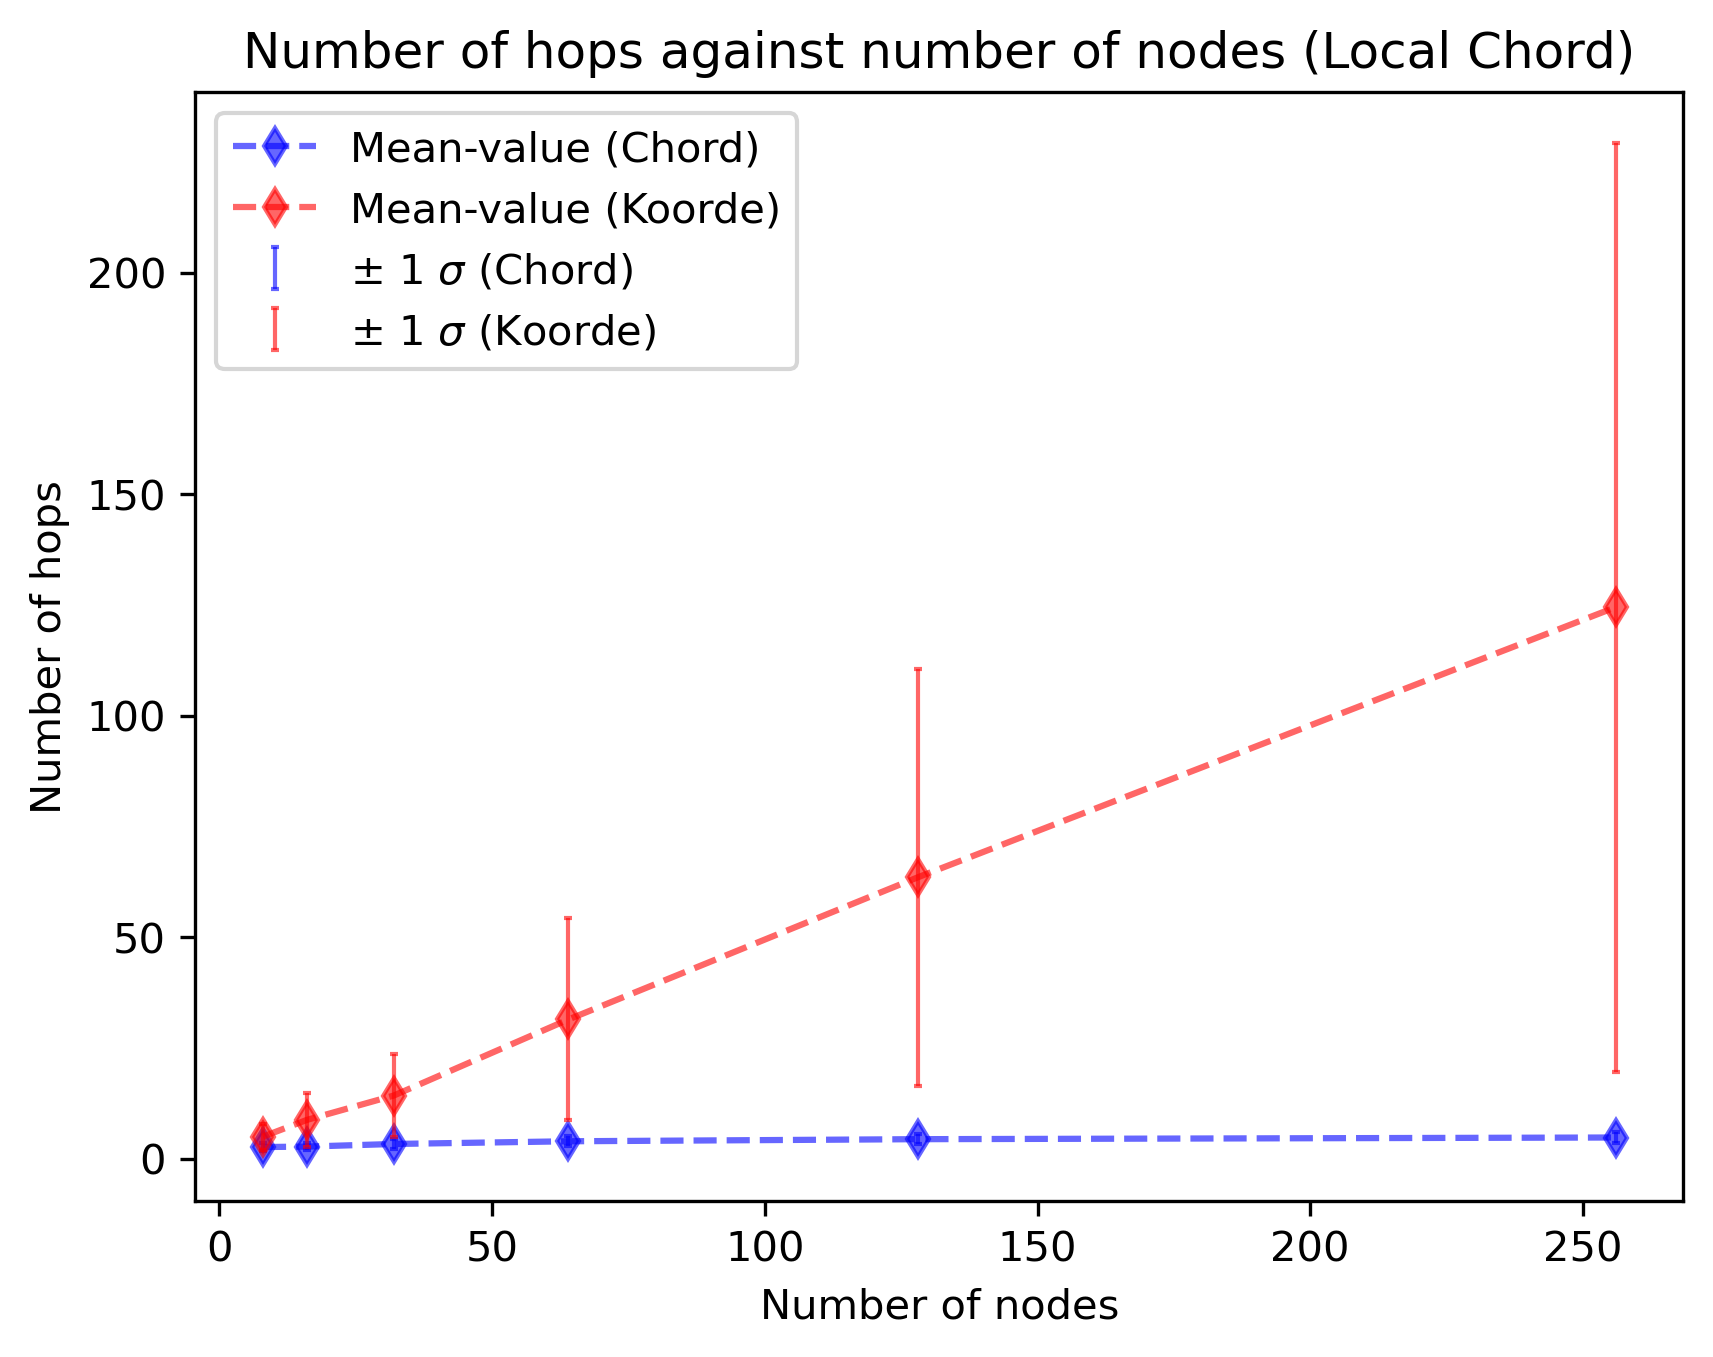

In [19]:
xnodes = np.array(num_nodes)
mean_hopsChord = np.mean(NumHopsChord, axis=0)
print(NumHopsChord)
mean_hopsKoorde = np.mean(NumHopsKoorde, axis=0)

std_hopsC = np.std(NumHopsChord, axis=0)
std_hopsK = np.std(NumHopsKoorde, axis=0)

whisker_plot(xnodes, (mean_hopsChord - std_hopsC), 2*std_hopsC,
                      ylabel="Number of hops",\
             xlabel="Number of nodes",\
             title="Number of hops against number of nodes (Local Chord)", \
            errbarlabel = r"$\pm$ 1 $\sigma$ (Chord)", \
                 centerlabel=r"Mean-value (Chord)")

whisker_plot(xnodes, (mean_hopsKoorde - std_hopsK), 2*std_hopsK,
                      ylabel="Number of hops",\
             xlabel="Number of nodes",\
             title="Number of hops against number of nodes (Local Koorde)", \
            errbarlabel = r"$\pm$ 1 $\sigma$ (Koorde)", \
                 centerlabel=r"Mean-value (Koorde)")

whisker_plot_combined(xnodes, (mean_hopsChord - std_hopsC), 2*std_hopsC,
                      (mean_hopsKoorde - std_hopsK), 2*std_hopsK,
                      ylabel="Number of hops",\
             xlabel="Number of nodes",\
             title="Number of hops against number of nodes (Local Chord)", \
            errbarlabelA = r"$\pm$ 1 $\sigma$ (Chord)", \
                 centerlabelA=r"Mean-value (Chord)", \
            errbarlabelB = r"$\pm$ 1 $\sigma$ (Koorde)", \
                 centerlabelB=r"Mean-value (Koorde)")

In [30]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

def plot_hist(values, xlabel="X-values", ylabel="PDF", title=""):
    plt.hist(values, color='black', bins=np.arange(0,np.max(values)+1)+0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    return

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


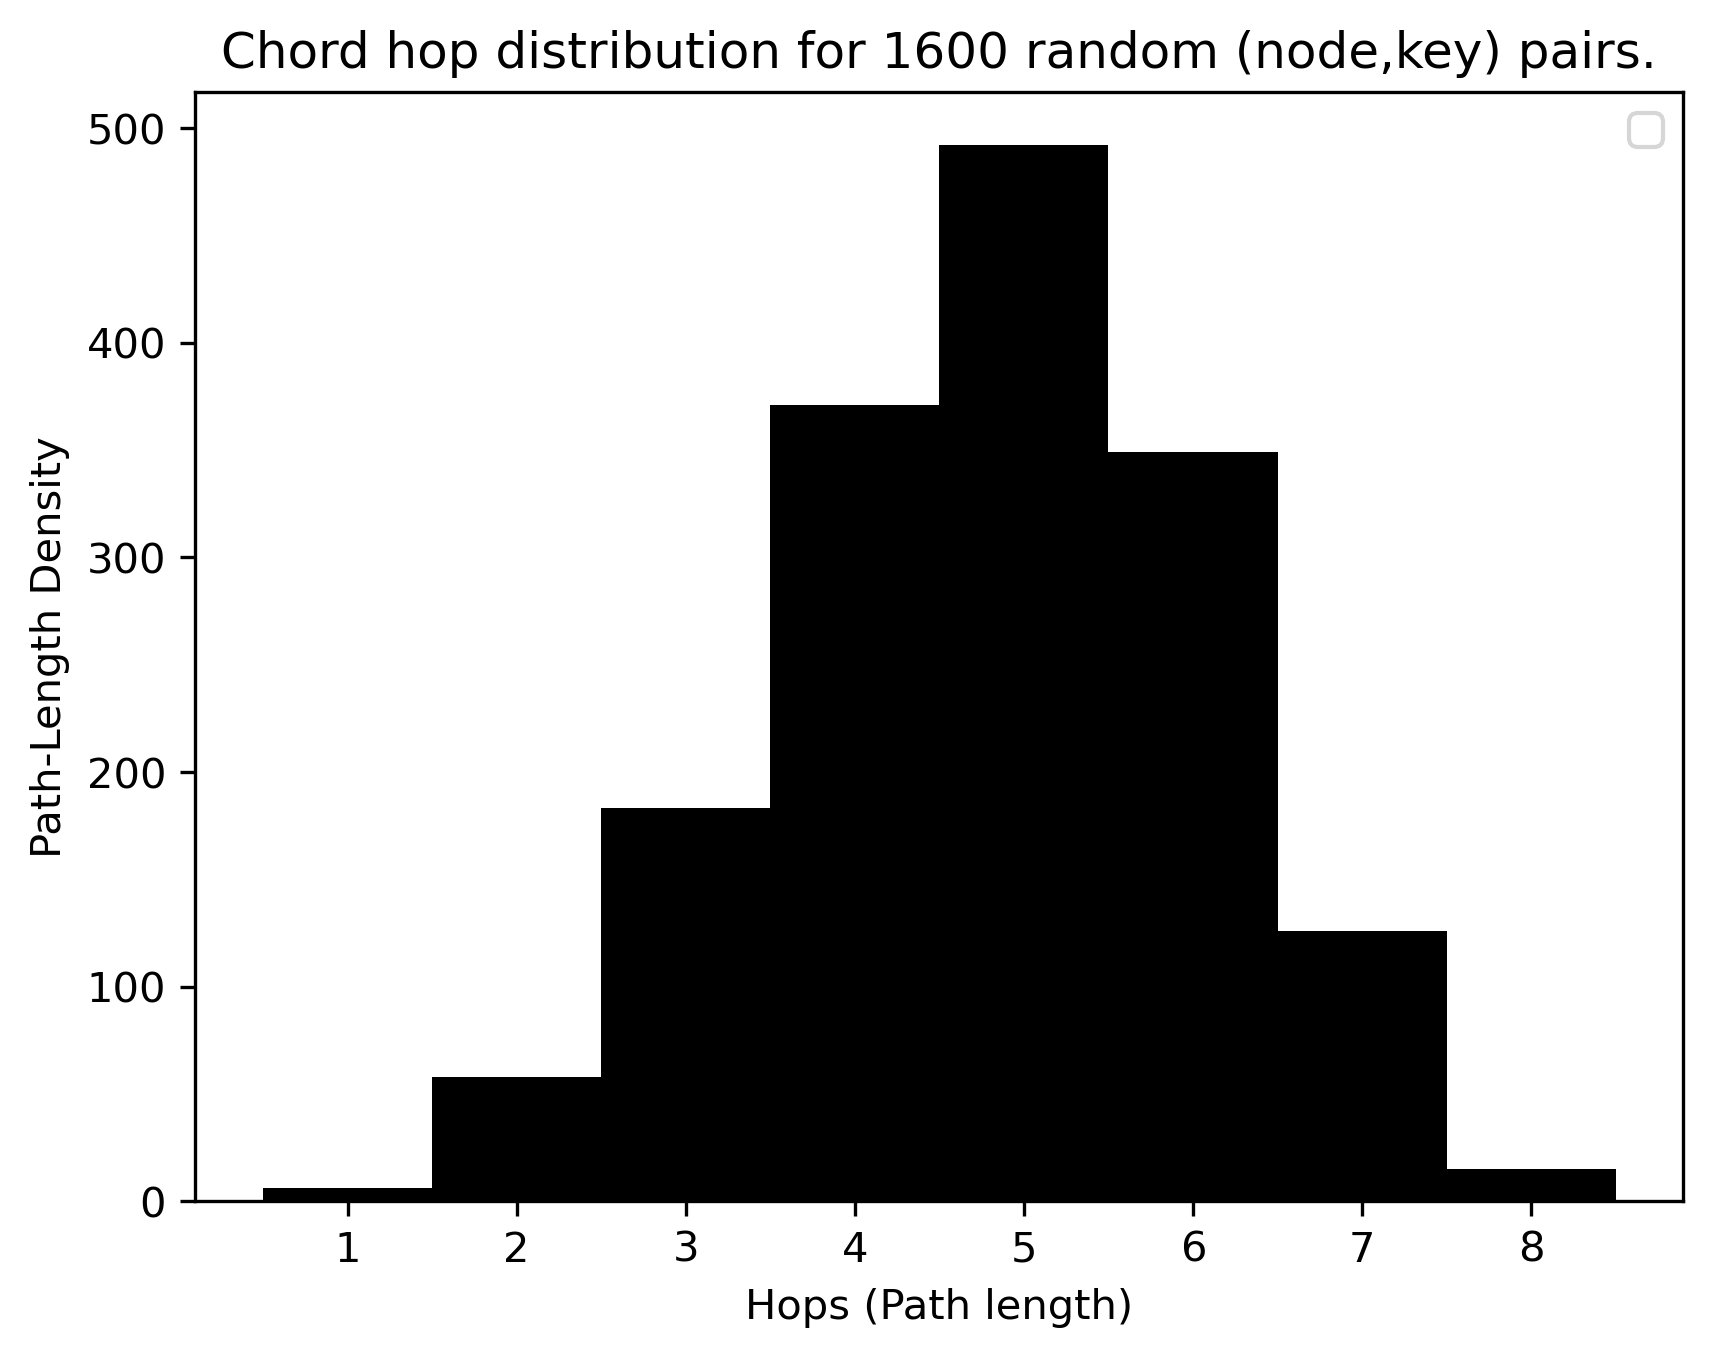

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


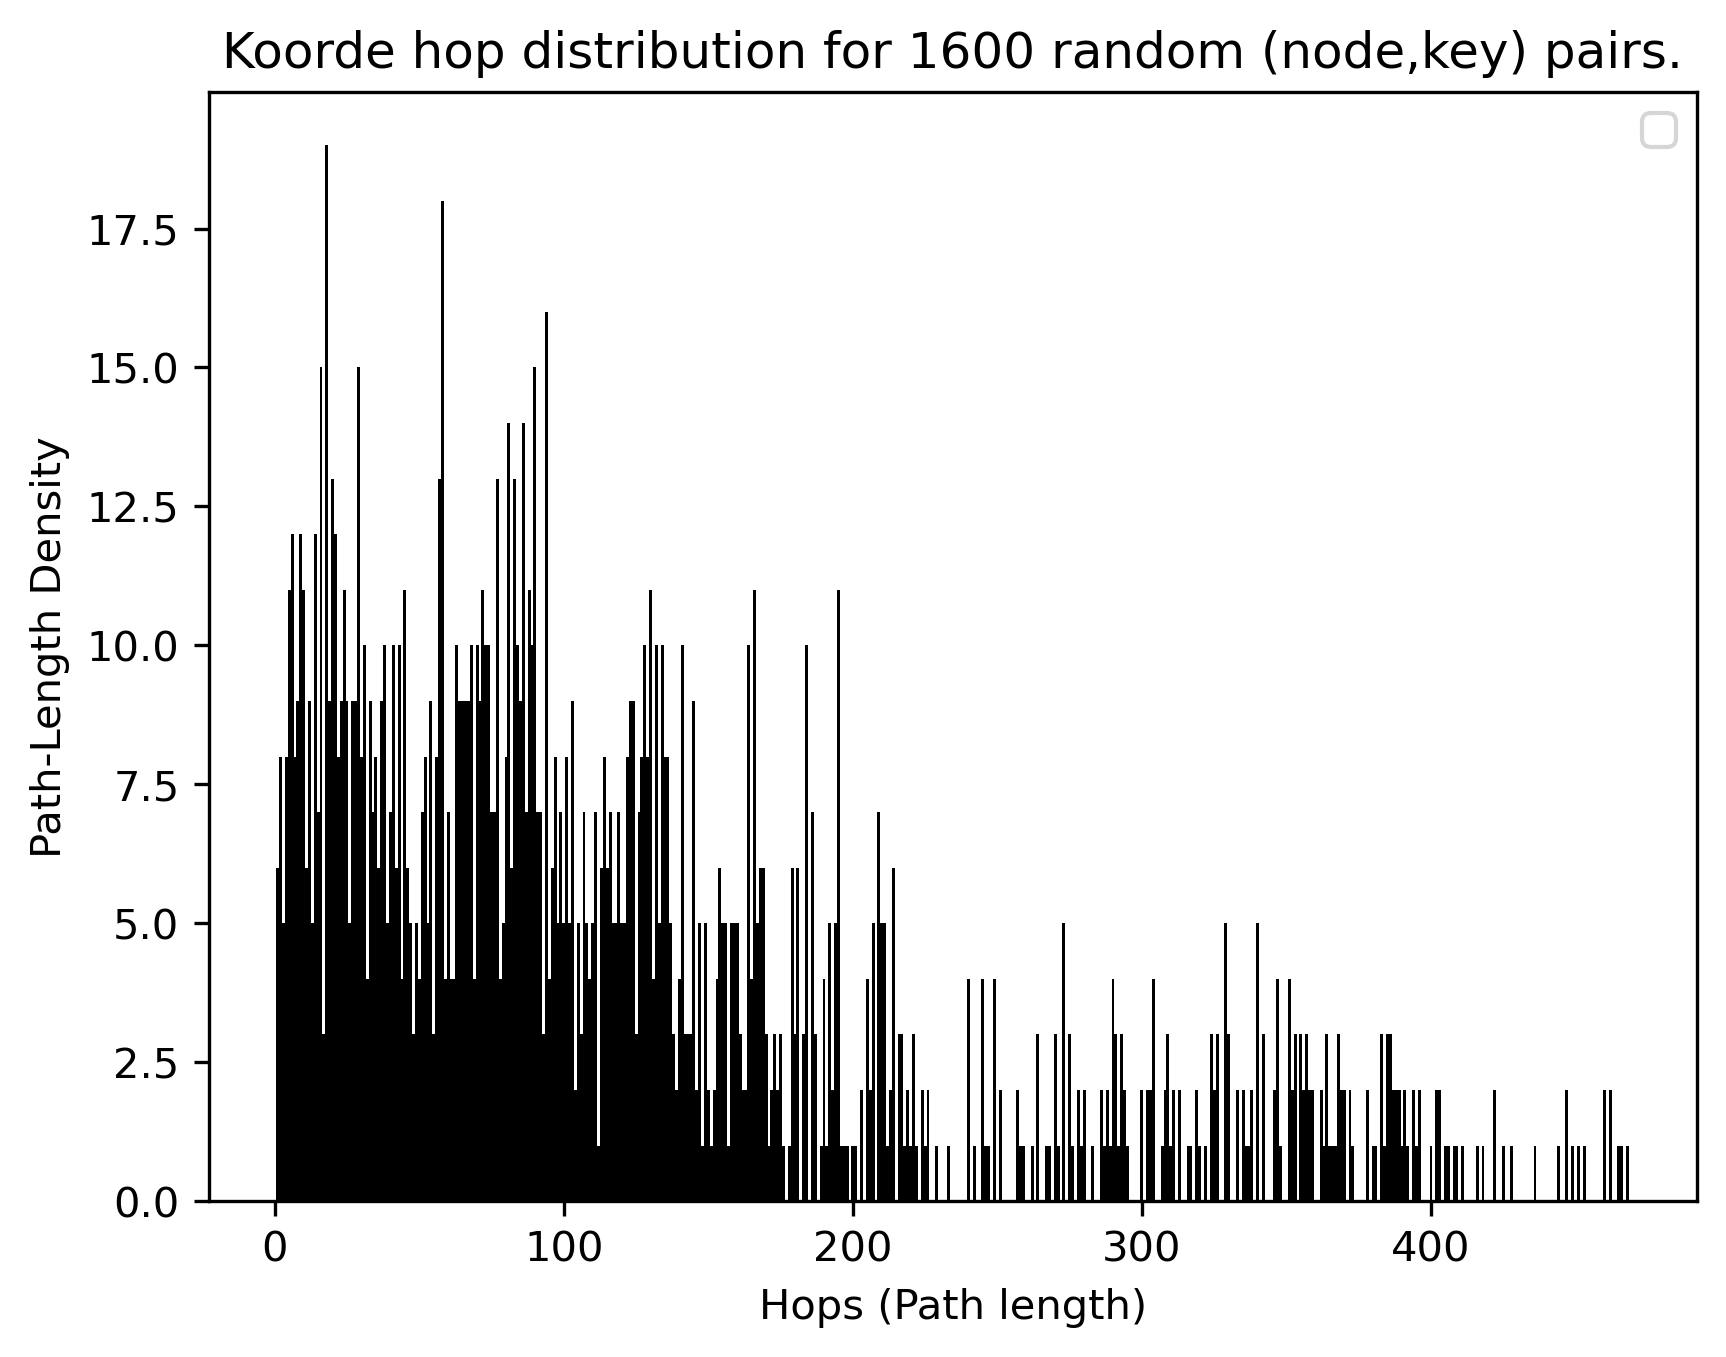

In [33]:
dist_finalC = NumHopsChord[:,-1]
dist_finalK = NumHopsKoorde[:,-1]

plot_hist(dist_finalC, xlabel="Hops (Path length)", ylabel="Path-Length Density", title=f"Chord hop distribution for {num_rep**2} random (node,key) pairs.")
plot_hist(dist_finalK, xlabel="Hops (Path length)", ylabel="Path-Length Density", title=f"Koorde hop distribution for {num_rep**2} random (node,key) pairs.")